In [1]:
#######
# Starter code for discretization for Markov Chain
#
# Stock Data:
#
# You will need to install the YahooFinance Python api
#
# Using Anaconda environment:
# - conda install -c conda-forge yfinance
#
# Using pip 
# - pip install yfinance
#
# Veryify it is installed by importing it in your Jupyter Notebook.
# If you cannot get it to install, you can always Google Search
# "install yfinance Python library"  and it will give you search results
# that walk you through.   As of 13-Nov-2024 both methods work.
#
# https://stackoverflow.com/questions/39636128/yahoo-finance-package-installation-in-anaconda
###

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import numpy.linalg

import yfinance as yf
import pandas as pd

In [3]:
#####
# 12-month data from 11/12/2023 to 11/12/2024
##
FY2024_START='2023-01-01'
FY2024_END='2023-11-13'

appleTicker='AAPL'
nvidiaTicker='NVDA'

In [4]:
NUM_BINS= 3

In [5]:
nvidiaData= yf.download(nvidiaTicker, start=FY2024_START,end= FY2024_END)
aaplData= yf.download(appleTicker, start=FY2024_START,end=FY2024_END)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
nvidiaData.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,14.851,14.996,14.096,14.315,14.305580,401277000
2023-01-04,14.567,14.853,14.241,14.749,14.739295,431324000
2023-01-05,14.491,14.564,14.148,14.265,14.255615,389168000
2023-01-06,14.474,15.010,14.034,14.859,14.849224,405044000
2023-01-09,15.284,16.056,15.141,15.628,15.617716,504231000


In [7]:
aaplData.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,130.279999,130.899994,124.169998,125.070000,123.768463,112117500
2023-01-04,126.889999,128.660004,125.080002,126.360001,125.045036,89113600
2023-01-05,127.129997,127.769997,124.760002,125.019997,123.718971,80962700
2023-01-06,126.010002,130.289993,124.889999,129.619995,128.271118,87754700
2023-01-09,130.470001,133.410004,129.889999,130.149994,128.795593,70790800


In [8]:
######
# To learn more, see multi-level columns in Pandas.
# They are kinda cool and make sense for complex aggregated data.
#
# https://pandas.pydata.org/docs/user_guide/advanced.html
#
# https://stackoverflow.com/questions/63107594/how-to-deal-with-multi-level-column-names-downloaded-with-yfinance
###
df_aapl_close = aaplData['Close']

In [9]:
df_nvidia_close= nvidiaData['Close']

In [10]:
df_aapl_close.shape

(217,)

In [11]:
df_nvidia_close.shape

(217,)

In [12]:
df_aapl_close.describe()

count    217.000000
mean     169.532489
std       16.599124
min      125.019997
25%      157.830002
50%      173.570007
75%      180.089996
max      196.449997
Name: Close, dtype: float64

In [13]:
df_nvidia_close.describe()

count    217.000000
mean      34.779470
std       10.428269
min       14.265000
25%       26.240999
50%       39.481998
75%       43.939999
max       49.355000
Name: Close, dtype: float64

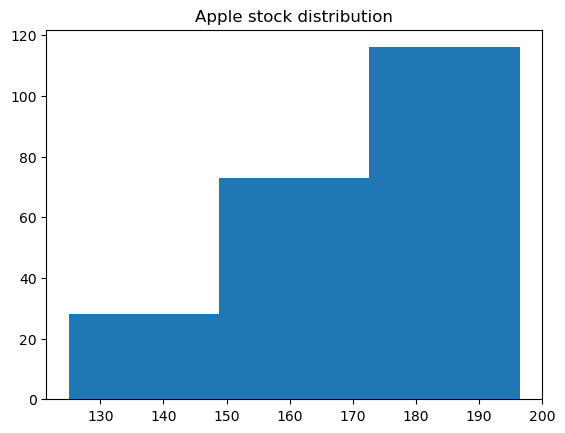

In [14]:
#####
# binCounts= number of examples in each bin
# binEdges-  left edge of each bin
# patches- rectangles used to plot histogram's bars
##

plt.figure(1)
plt.title('Apple stock distribution')
binCountsAAPL, binEdgesAAPL, patchesAAPL= plt.hist(df_aapl_close,NUM_BINS)

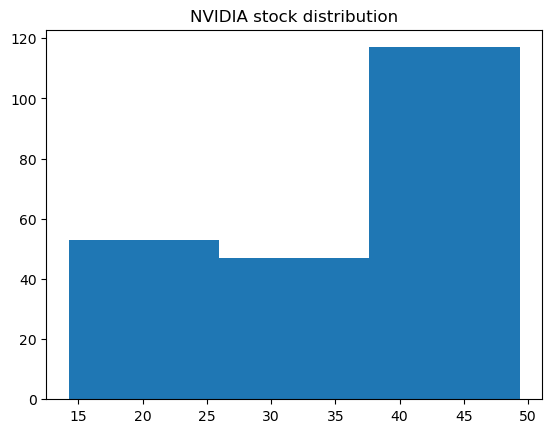

In [15]:
#####
# binCounts= number of examples in each bin
# binEdges-  left edge of each bin
# patches- rectangles used to plot histogram's bars
##

plt.figure(2)
plt.title('NVIDIA stock distribution')
binCountsNVDA, binEdgesNVDA, patchesNVDA= plt.hist(df_nvidia_close,NUM_BINS)

In [16]:
#####
# checkState
#
# Given array of bin edges and temperature value, translate
# the temperature into a state as defined by bin boundaries.
#
# temp= the temp value
# binEdges= temperature intervals defining states
#
# returns state value
##

def checkState(closingPrice, binEdges):
    leftEdge= 0
    rightEdge= 0
    stateValue= -1
    
    for e in range(0,len(binEdges)-1):
        leftEdge= binEdges[e]
        rightEdge= binEdges[e + 1]
        
        if (e != len(binEdges)-2):
            if (closingPrice >= leftEdge) & (closingPrice < rightEdge):
                stateValue= e
                break
        else:
            if (closingPrice >= leftEdge) & (closingPrice <= rightEdge):
                stateValue= e
                break
                
    return stateValue

In [17]:
#####
# Quick tester for checkState
##
checkState(90, binEdgesAAPL)

-1

In [18]:
checkState(250, binEdgesAAPL)

-1

In [19]:
def buildMarkovMatrix(trMatrix, df_data, binEdges):
    sCurr= 0
    sNext= 0
    firstTime= True
    DEBUG= True

    for price in df_data:
        print(f'buildMarkovMatrix:  price={price}')
        if(firstTime):
            sNext= checkState(price, binEdges)
            sCurr= sNext
            firstTime= False
            if (DEBUG):
                print(f'buildMarkovMatrix:  temp={price}:  (curr, next)= (S{sCurr},S{sNext})')
            continue;
        
        sCurr= sNext
        sNext= checkState(price, binEdges)
    
        if (DEBUG):
            print(f'buildMarkovMatrix:  price= {price}:  (curr, next)= (S{sCurr},S{sNext})')

        trMatrix[sCurr, sNext]= trMatrix[sCurr,sNext] + 1

In [20]:
######
#  set the number of states 
###
numStates= len(binEdgesAAPL)-1
numStates

3

In [21]:
#####
# Initialize Markov Matrix to zeros
###
trMatrixAAPL= np.zeros((numStates,numStates),dtype=np.float64)
trMatrixNVDA= np.zeros((numStates,numStates),dtype=np.float64)

In [22]:
buildMarkovMatrix(trMatrixAAPL, df_aapl_close, binEdgesAAPL)

buildMarkovMatrix:  price=125.06999969482422
buildMarkovMatrix:  temp=125.06999969482422:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=126.36000061035156
buildMarkovMatrix:  price= 126.36000061035156:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=125.0199966430664
buildMarkovMatrix:  price= 125.0199966430664:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=129.6199951171875
buildMarkovMatrix:  price= 129.6199951171875:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=130.14999389648438
buildMarkovMatrix:  price= 130.14999389648438:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=130.72999572753906
buildMarkovMatrix:  price= 130.72999572753906:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=133.49000549316406
buildMarkovMatrix:  price= 133.49000549316406:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=133.41000366210938
buildMarkovMatrix:  price= 133.41000366210938:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=134.75999450683594
buildMarkovMatrix:  price= 134.7599945068

In [23]:
trMatrixAAPL

array([[ 24.,   4.,   0.],
       [  3.,  63.,   7.],
       [  0.,   6., 109.]])

In [24]:
buildMarkovMatrix(trMatrixNVDA, df_nvidia_close, binEdgesNVDA)

buildMarkovMatrix:  price=14.3149995803833
buildMarkovMatrix:  temp=14.3149995803833:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=14.74899959564209
buildMarkovMatrix:  price= 14.74899959564209:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=14.265000343322754
buildMarkovMatrix:  price= 14.265000343322754:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=14.859000205993652
buildMarkovMatrix:  price= 14.859000205993652:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=15.628000259399414
buildMarkovMatrix:  price= 15.628000259399414:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=15.909000396728516
buildMarkovMatrix:  price= 15.909000396728516:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=16.000999450683594
buildMarkovMatrix:  price= 16.000999450683594:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=16.51099967956543
buildMarkovMatrix:  price= 16.51099967956543:  (curr, next)= (S0,S0)
buildMarkovMatrix:  price=16.89900016784668
buildMarkovMatrix:  price= 16.89900016784668: 

In [25]:
trMatrixNVDA

array([[ 52.,   1.,   0.],
       [  0.,  45.,   2.],
       [  0.,   1., 115.]])

In [26]:
#####
# Measure row count and column count then
# normalize row counts to make distributions
#
# result is Markov Matrix, p 
##

def normalizeMarkovMatrix(trMatrix):
    rows,cols= trMatrix.shape

    for i in range(0,rows):
        rowSum= sum(trMatrix[i])
    
        ###
        # Debug artifact
       #print(rowSum)
    
    
        if(rowSum != 0):
            trMatrix[i]= trMatrix[i]/rowSum

    return trMatrix

In [27]:
normalizeMarkovMatrix(trMatrixAAPL)

array([[0.85714286, 0.14285714, 0.        ],
       [0.04109589, 0.8630137 , 0.09589041],
       [0.        , 0.05217391, 0.94782609]])

In [28]:
normalizeMarkovMatrix(trMatrixNVDA)

array([[0.98113208, 0.01886792, 0.        ],
       [0.        , 0.95744681, 0.04255319],
       [0.        , 0.00862069, 0.99137931]])

In [29]:
#####
# TODO
#
# 1.  Iterate h-step transition and demonstrate steady state distribution
#   Check example code in the findLandingtoConvergence. You're basically looking at that fxn for diff numbers
# of states and different initial states (P0) (ex. [1, 0,0,0]). With your transition matrix  
#
# 2.  Test forcast
#     a) begin with any initial state as distribution row vector pi_0= [ s_0,..., s_n]
#     b) select time-step h=  1, 2, 3, 4,...
#     c) compute h-step transition matrix
#     d) apply h-step transition matrix
#     e) validate resulting vector pi
#      validate means select state or time step that has the largest prob value (greatest of pi)
##

In [30]:
#states:
#      S_o,..., S_n 
#
#      Initialize to single state, state S_i
initState= 0
P0= np.zeros(NUM_BINS)
P0[initState]= 1

In [31]:
P0

array([1., 0., 0.])

In [32]:
#######
#  run to convergence or h-many steps, whichever comes first
###

def findLandingToConvergence(numTimeSteps,P0,trMatrix):
    #####
    # Initialize P_i to the landing distribution at time t_0
    ###
    Pi= P0
    
    for i in range(0,numTimeSteps):
        Pi_prev= Pi
        Pi= np.matmul(Pi,trMatrix)
        np.set_printoptions(precision=3,floatmode='fixed')

        #####
        # You've reached convergence when P_i does not change.
        # That is Pi_prev == Pi.  Programmatically this is achieved
        # by checking for equality.  This returns an array of True/False
        # results.  We sum them together (i.e. True=1, False=0) and check
        # if the sum equals bin count to determine if each position matches.
        ##
        if ( (i> 1) and (sum(Pi_prev == Pi) == NUM_BINS) ):
            print(f'converged iteration({i}):  P_{i}= {Pi}')
            break;

    print(f'landing prob P_{i+1}:  P_{i+1}= {Pi}')

    return Pi

In [33]:
Pi=findLandingToConvergence(10,P0,trMatrixNVDA)

landing prob P_10:  P_10= [0.827 0.143 0.030]


In [34]:
print(findLandingToConvergence(20,P0,trMatrixNVDA))
print(findLandingToConvergence(40,P0,trMatrixNVDA))
print(findLandingToConvergence(80,P0,trMatrixNVDA))

landing prob P_20:  P_20= [0.683 0.215 0.101]
[0.683 0.215 0.101]
landing prob P_40:  P_40= [0.467 0.257 0.276]
[0.467 0.257 0.276]
landing prob P_80:  P_80= [0.218 0.230 0.552]
[0.218 0.230 0.552]


In [35]:
####
# verify that landing distribution P_i obeys total probability
##
np.sum(Pi)

1.0

In [36]:
h=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
initState= 0
P0= np.zeros(NUM_BINS)
P0[initState]= 1

for i in range(NUM_BINS):
    initState=i
    P0[initState]=1
    for j in h:
        findLandingToConvergence(j,P0,trMatrixNVDA)

landing prob P_1:  P_1= [0.981 0.019 0.000]
landing prob P_2:  P_2= [9.626e-01 3.658e-02 8.029e-04]
landing prob P_3:  P_3= [0.944 0.053 0.002]
landing prob P_4:  P_4= [0.927 0.069 0.005]
landing prob P_5:  P_5= [0.909 0.083 0.007]
landing prob P_6:  P_6= [0.892 0.097 0.011]
landing prob P_7:  P_7= [0.875 0.110 0.015]
landing prob P_8:  P_8= [0.859 0.122 0.020]
landing prob P_9:  P_9= [0.842 0.133 0.025]
landing prob P_10:  P_10= [0.827 0.143 0.030]
landing prob P_11:  P_11= [0.811 0.153 0.036]
landing prob P_12:  P_12= [0.796 0.162 0.042]
landing prob P_13:  P_13= [0.781 0.171 0.049]
landing prob P_14:  P_14= [0.766 0.179 0.055]
landing prob P_15:  P_15= [0.751 0.186 0.063]
landing prob P_16:  P_16= [0.737 0.193 0.070]
landing prob P_17:  P_17= [0.723 0.199 0.078]
landing prob P_18:  P_18= [0.710 0.205 0.085]
landing prob P_19:  P_19= [0.696 0.210 0.093]
landing prob P_20:  P_20= [0.683 0.215 0.101]
landing prob P_1:  P_1= [0.981 0.976 0.043]
landing prob P_2:  P_2= [0.963 0.954 0.084

In [37]:
# Compartmentalize it. Don't think of anything else unless you can get the markov chain to predict the thing first, then compare.

########
# TODO
#
# Write a function that performs prediction using a markov chain.
# For example, markovChainPrediction(...)
#
# h=[1,2,3,4,5,6,7,8,9,10]
# P_0=[1, 0, 0] # this is the probabilities of it being in state at time step 0. We're initializing the start.
#     transMatrix=normalizeMarkovMatrix(insertparametershere)
# starting in state t where will i be?
# P_i = landing probability.
# return what the maximum P_i
# check on if there's a "python maximum position in array" function
     # np.argmin(values)
# Algorithm for prediction using markov chain.
# def markovChainPrediction(transMatrix, P_0, h, M):
    
#
# 1.  select a time horizon for prediction, i.e. time steps h= 1,2,3,...10
# initialize array, that time horizon will say how many times you mult trans matrix by itself
# 2.  compute the h-step transition matrix M^{h}
# select a time horizon (h) then compute M^(h) where M is a parameter in the code
# 3.  obtain data structure containing Closing price measurements,  m_1, m_2,..., m_n
# Dataframe or Series and then you just call it/segment it out
# 4.  begin at position in price measurements,  m_i
# Pick one closing price (he recommends doing it from the first one). He'd write a routine that does a prediction given a
# measurement at some time step, then predict what this should be. "Given this transition matrix and this time step,"
# "what state does the Markov chain say it'd be in?"
# Write a fxn that says here's my dataframe and its position, at time step t, h steps later, where does the markov chain say
# my state should be?
# 5.  convert to state  S_i = checkState(m_i)
# (see above)
# 6.  set this as your landing distribution at time t0, namely P_0
# The landing distribution is a vector that has as many positions as you have states. So P0 is prob of M being that state
#at time t0.
# 7.  compute the landing distribution after h-many time-steps, P_0 x M^{h}
#
# 8.  step #7 results in landing distribution P_h, find the state S_i with the max probability S_max
#
# 9.  Given your starting state S_i at m_i,  find the measurement h-steps away m_(i+h)
#     and convert it to a state  S_(i+h) = checkState( m_(i+h) )
#
# 10. test if the predicted end state that the markov chain says  S_max == S_(i+h) 
#     If yes, then increment successes= sucesses+1
#     if no, then increment failures= failures+1
#
# # For experiments, you're varying time steps (h), and the amount of states.
# 11. Compute rate= successes/(successes + failure),  this is your generalization.

In [38]:
FY2021_START='2021-01-01'
FY2023_END='2023-11-13'

FY2019_START='2019-01-01'

nvidiaTicker='NVDA'

In [39]:
nvidiaData2= yf.download(nvidiaTicker, start=FY2021_START,end= FY2023_END)

[*********************100%%**********************]  1 of 1 completed


In [40]:
nvidiaData5= yf.download(nvidiaTicker, start=FY2019_START,end= FY2023_END)

[*********************100%%**********************]  1 of 1 completed


In [41]:
# 2 years
df_nvidia_close2= nvidiaData2['Close']

# 5 years
df_nvidia_close5= nvidiaData5['Close']

In [42]:
NUM_BINS= 10

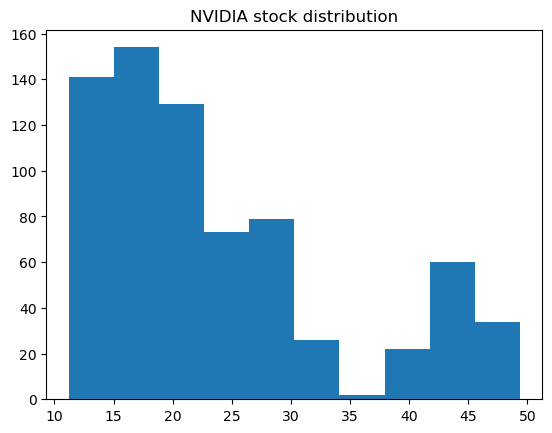

In [43]:
plt.figure(2)
plt.title('NVIDIA stock distribution')
binCountsNVDA2, binEdgesNVDA2, patchesNVDA2= plt.hist(df_nvidia_close2,NUM_BINS)

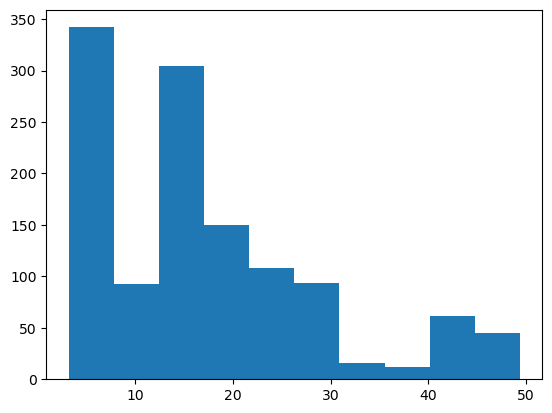

In [44]:
binCountsNVDA5, binEdgesNVDA5, patchesNVDA5= plt.hist(df_nvidia_close5,NUM_BINS)

In [45]:
print(checkState(40, binEdgesNVDA2))
print(checkState(40, binEdgesNVDA5))

7
7


In [46]:
numStates= len(binEdgesNVDA2)-1
numStates

10

In [47]:
trMatrixNVDA2= np.zeros((numStates,numStates),dtype=np.float64)
trMatrixNVDA5= np.zeros((numStates,numStates),dtype=np.float64)

In [48]:
buildMarkovMatrix(trMatrixNVDA2, df_nvidia_close2, binEdgesNVDA)

buildMarkovMatrix:  price=13.113499641418457
buildMarkovMatrix:  temp=13.113499641418457:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=13.404749870300293
buildMarkovMatrix:  price= 13.404749870300293:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=12.614500045776367
buildMarkovMatrix:  price= 12.614500045776367:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=13.343999862670898
buildMarkovMatrix:  price= 13.343999862670898:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=13.276749610900879
buildMarkovMatrix:  price= 13.276749610900879:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=13.621500015258789
buildMarkovMatrix:  price= 13.621500015258789:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=13.484749794006348
buildMarkovMatrix:  price= 13.484749794006348:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=13.531749725341797
buildMarkovMatrix:  price= 13.531749725341797:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=13.200249671936035
buildMarkovMatrix:  p

In [49]:
trMatrixNVDA2

array([[368.000,   6.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   8.000],
       [  5.000, 106.000,   2.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   1.000, 115.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  9.000,   0.000,   0.000,   

In [50]:
normalizeMarkovMatrix(trMatrixNVDA2)

array([[0.963, 0.016, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.021],
       [0.044, 0.938, 0.018, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.009, 0.991, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.083, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.917]])

In [51]:
buildMarkovMatrix(trMatrixNVDA5, df_nvidia_close5, binEdgesNVDA)

buildMarkovMatrix:  price=3.4054999351501465
buildMarkovMatrix:  temp=3.4054999351501465:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=3.1997499465942383
buildMarkovMatrix:  price= 3.1997499465942383:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=3.404750108718872
buildMarkovMatrix:  price= 3.404750108718872:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=3.5850000381469727
buildMarkovMatrix:  price= 3.5850000381469727:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=3.4957499504089355
buildMarkovMatrix:  price= 3.4957499504089355:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=3.564500093460083
buildMarkovMatrix:  price= 3.564500093460083:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=3.6307499408721924
buildMarkovMatrix:  price= 3.6307499408721924:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=3.720750093460083
buildMarkovMatrix:  price= 3.720750093460083:  (curr, next)= (S-1,S-1)
buildMarkovMatrix:  price=3.760999917984009
buildMarkovMatrix:  price= 3

In [52]:
trMatrixNVDA5

array([[368.000,   6.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,  10.000],
       [  5.000, 106.000,   2.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   1.000, 115.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [  0.000,   0.000,   0.000,   0.000,   0.000,   0.000,   0.000,
          0.000,   0.000,   0.000],
       [ 11.000,   0.000,   0.000,   

In [53]:
normalizeMarkovMatrix(trMatrixNVDA2)

array([[0.963, 0.016, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.021],
       [0.044, 0.938, 0.018, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.009, 0.991, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000],
       [0.083, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.917]])

In [54]:
initState= 0
P0= np.zeros(NUM_BINS)
P0[initState]= 1

P0

array([1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000])

In [55]:
PiN2= findLandingToConvergence(100,P0,trMatrixNVDA2)

landing prob P_100:  P_100= [0.526 0.159 0.179 0.000 0.000 0.000 0.000 0.000 0.000 0.136]


In [56]:
PiN5= findLandingToConvergence(100,P0,trMatrixNVDA5)

landing prob P_100:  P_100= [1.437e+275 1.743e+273 7.182e+270 0.000e+000 0.000e+000 0.000e+000
 0.000e+000 0.000e+000 0.000e+000 3.035e+276]


In [57]:
np.sum(PiN2)

1.0000000000000004

In [58]:
np.sum(PiN5)

3.180892227021948e+276

In [59]:
########
# Experiments
#
# This will appear in your written work.   You will design a function called
# runExperiment(...)  that allows you to vary the states and the time horizon
#
# 1.  Select a company
# 2.  Donwload 2 years worth of stock data
# 3.  Using Closing Price design an experemnt that measures generlization performance of
#     - Markov Chain of varying state sizes, 2, 3, 4,...10
#
#     - Measure generalization performance for predictions on time horizons of timesteps (days)
#       h= 1,...,10
#
#     - discuss how generalization performance changes as you change the number of states and
#       the time horizon h.   For example...
#
#       generalizaton(states=2, h=1)
#       generalizaton(states=2, h=2)
#       generalizaton(states=2, h=3)
#            .
#            .
#            .
#       generalizaton(states=10, h=1)
#       generalization(states=10,h=2)
#            .
#            .
#            .
#       generalization(states=10,h=10)
####

# just running this a bunch of times and analyzing results. use abstraction (do a for loop)

In [60]:
from numpy.linalg import matrix_power
def markovchainPrediction(startState, h, trMatrix):
    P_0 = np.zeros(NUM_BINS)
    P_0[startState] = 1.0
    hStepTr = matrix_power(trMatrix,h)
    P_i= np.matmul(P_0, hStepTr)
    
    return max(P_i)

In [61]:
def evaluatePrediction(h, closingMatrix, trMatrix):
    correct=0
    incorrect=0
    for t in range(h):
        startVal= closingMatrix[t]
        startState = checkState(startVal)
        for i in h:
            if (t+i <= len(timeSeries -1)):
                predEndState= markovchainPrediction(startState, i, trMatrix)
                actualEndState= checkState(closingMatrix[t+i])
                if(actualEndState == predLandState):
                    correct=correct+ 1
                else:
                    incorrect= incorrect+1
    return (correct, incorrect)
# h=[1,2,3,4,5,6,7,8,9,10]
# predictRate = correct/(correct+incorrect)

In [62]:
markovchainPrediction(initState, 10, trMatrixNVDA2)

0.7623058544376284

In [63]:
evaluatePrediction(10, nvidiaData2, trMatrixNVDA2)

TypeError: object of type 'int' has no len()

In [64]:
markovchainPrediction(initState, 10, trMatrixNVDA5)

2.5975746104422864e+26

In [65]:
evaluatePrediction(10, nvidiaData5, trMatrixNVDA5)

TypeError: object of type 'int' has no len()

In [66]:
def generalize(states, h, closingMatrix,trMatrix):
        correct=evaluatePrediction(h, closingMatrix, trMatrix)[0]
        incorrect=evaluatePrediction(h, closingMatrix, trMatrix)[1]
        predictRate = correct/(correct+incorrect)
        return predictRate

In [67]:
generalize(NUM_BINS, 10, nvidiaData2, trMatrixNVDA2)

TypeError: object of type 'int' has no len()

In [68]:
generalize(NUM_BINS, 10, nvidiaData5, trMatrixNVDA5)

TypeError: object of type 'int' has no len()